In [209]:
import urllib
from datetime import datetime, timedelta, date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import glob
from tqdm.notebook import tqdm

%matplotlib inline

In [21]:
pd.options.mode.chained_assignment = None
projectFolder = '/Users/alexiseggermont/Dropbox/01. Personal/04. Models/58. Coronavirus/'
populations = pd.read_excel(projectFolder+"population.xlsx")
start_date = datetime(year = 2020, month = 3, day = 22).date()
end_date = datetime.now().date()

In [22]:
#1 Download the data

for n in range(int ((end_date - start_date).days)):
    date_US =  (start_date + timedelta(n)).strftime("%m-%d-%Y")
    date_INT =  (start_date + timedelta(n)).strftime("%Y-%m-%d")
    url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/"+date_US+".csv"
    g = urllib.request.urlopen(url)
    with open(projectFolder+'github-data/daily/'+date_INT+".csv",'wb') as f:
        f.write(g.read())

In [23]:
# Aggregate into a dataframe

all_files = glob.glob(projectFolder + "github-data/daily/*.csv")

listOfDf = []

for filename in all_files:
    dft = pd.read_csv(filename, index_col=None, header=0)
    dft['Date'] = pd.to_datetime(filename.replace(projectFolder + "github-data/daily/",'').replace(".csv",''))
    dft = dft.rename(columns={'Province/State': 'Province_State', 'Country/Region': 'Country_Region'})
    
    listOfDf.append(dft)

df = pd.concat(listOfDf, axis=0, ignore_index=True)
df['Country_Region'] = df['Country_Region'].str.replace('South Korea','Korea, South').str.replace('Mainland China','China').str.replace('United Kingdom','UK').str.replace('Republic of Korea','Korea, South').str.replace("Iran \(Islamic Republic of\)",'Iran').str.replace("Viet Nam","Vietnam")


In [24]:
# Add missing country data for each date, for cleaner visualisation
# Speed here can no doubt be improved

countries = df['Country_Region'].unique()
dates = df['Date'].unique()
for c in tqdm(countries):
    for d in dates:
        subdf = df[df['Country_Region']==c]
        subdf = subdf[subdf['Date']==d]
        if len(subdf) == 0:
            df = df.append({'Country_Region':c,'Date':d,'Deaths':0,'Confirmed':0,'Recovered':0},ignore_index=True)

In [25]:
df['Active'] = df['Confirmed']-df['Deaths']-df['Recovered']
df = df[['Date','Country_Region','Confirmed','Deaths','Recovered','Active']].groupby(['Date','Country_Region']).agg('sum').reset_index()
df = df.sort_values('Date')

In [26]:
#3 visualize case breakdown by country

def breakdown(countries):
    globalLimit = max(df[df["Country_Region"].isin(countries)]['Confirmed'])
    
    for country in countries:
        print(country)
        
        subdf = df[df["Country_Region"]==country]

        # Your x and y axis
        x=subdf.Date
        y=[subdf.Recovered, subdf.Active, subdf.Deaths ]

        # use a known color palette (see..)
        pal = sns.color_palette("Set1")
        plt.figure(figsize=(13,8))
        pal = ["#dfd066","#bf220d", "#141b24"]
        plt.stackplot(x,y, labels=['Recovered','Active','Deaths'], colors=pal, alpha=1)
        plt.ylim(None, globalLimit*1.05)
        plt.legend(loc='upper left')

        plt.show()

Belgium


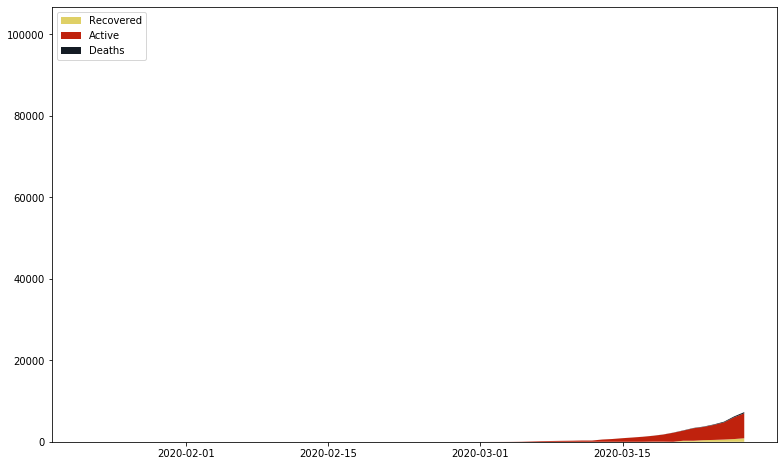

Netherlands


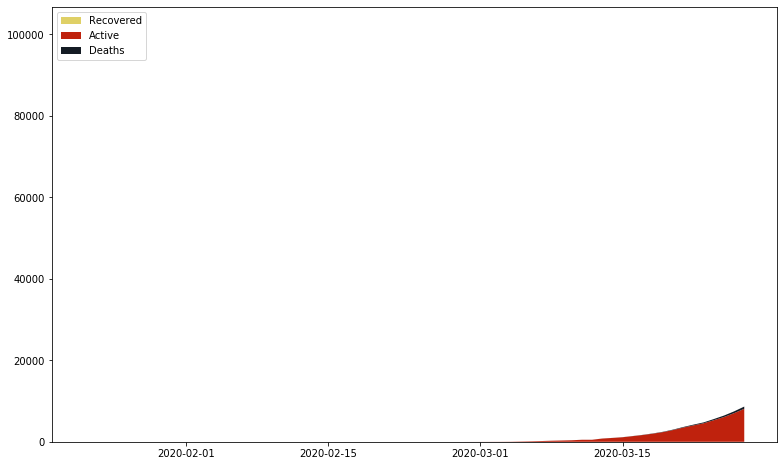

Singapore


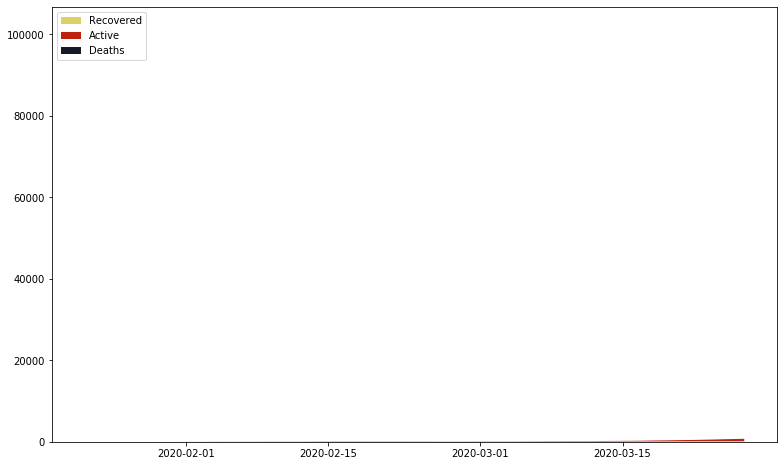

US


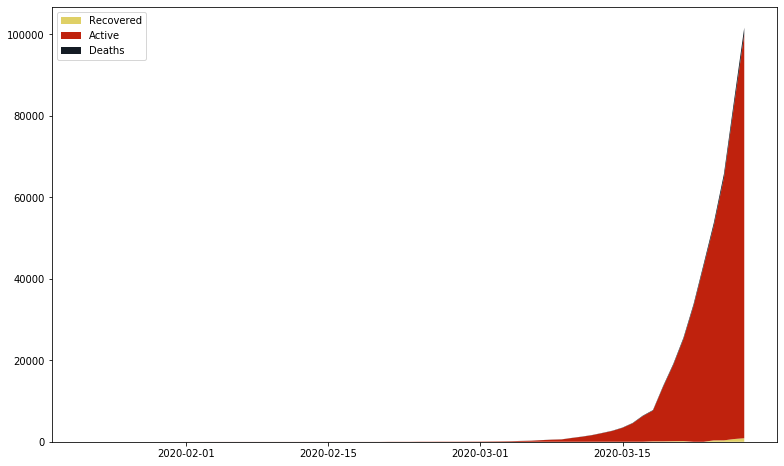

In [27]:
breakdown(["Belgium","Netherlands","Singapore","US"])

In [28]:
# This function gives the number of days between the moment a country reached x deaths, and the moment China did.
# It is used to remove time delays when graphing in order to more easily compare progression between countries

def delayForXDeaths(country, x):
    dfd = df[['Country_Region','Date','Deaths']]

    #We compute the time difference with the earliest epidemic, i.e. China
    dfd1 = dfd[dfd['Country_Region']=="China"]
    dfd2 = dfd[dfd['Country_Region']==country]
    daysSinceXCasesInChina = (datetime.today() - pd.to_datetime((dfd1[dfd1["Deaths"]>x]['Date'])).iloc[0])/ timedelta (days=1)
    try:
        daysSinceXCasesInCountry = (datetime.today() - pd.to_datetime((dfd2[dfd2["Deaths"]>x]['Date'])).iloc[0])/ timedelta (days=1)
    except:
        return 999
    delta = -int(round(daysSinceXCasesInChina - daysSinceXCasesInCountry,0))
    return delta

In [29]:
#4 compare several countries

def compareCountries(df,metric,countries,shifts,scale,perCapita = False,cumulative = True, smoothing = 1):
    
    # Set chart title
    title = metric
    if perCapita:
        title = title+" per thousand people"
    if cumulative:
        title = "Cumulative "+ title
    else:
        title = title + " per day"
    title = title.title()
    
    # Prepare chart dataframe
    df = df[df['Country_Region'].isin(countries)]

    if perCapita:
        df = df.merge(populations, left_on = "Country_Region", right_on = "Country")
        df[metric] = df[metric]/df["population_2020"]
    
    # Create one line per country
    data = []
    for country, shift in zip(countries,shifts):

        df_country = df[df['Country_Region']==country]
        df_country[metric] = df_country[metric].shift(shift)
        #df_country = df_country.assign(metric=df_country[metric].shift(shift))###
        df_country[metric] = df_country[metric].rolling(window=smoothing).mean()
        if cumulative:
            values = df_country[metric]
        else:
            values = df_country[metric].diff()
            
        trace = go.Scatter(
            #x = df_country['Date'],
            x = list(range(len(df_country))),
            y = values,
            mode = 'lines',
            name = country
        )
        data.append(trace)

        layout = dict(
        title=title,
        yaxis = dict(type = scale),
    )

    fig = dict(data=data, layout=layout)
    iplot(fig)

In [30]:
df = df.sort_values(['Date','Deaths'], ascending = [True,False])
#countries = df['Country_Region'].unique() #This will choose all countries
countries = ["Belgium","US","UK","Italy","Spain","Germany","China","France"]

# To align countries, use the delayForDeaths function
delays = [delayForXDeaths(x,90) for x in countries]
# To keep the real timeline, just use a list of 0s as the delays
#delays = [0,0,0,0,0,0,0,0]

# Dataset can be "Deaths", "Confirmed", "Active" or "Recovered"
compareCountries(df,"Deaths",countries,delays,"log", perCapita = False, cumulative = True, smoothing = 1)

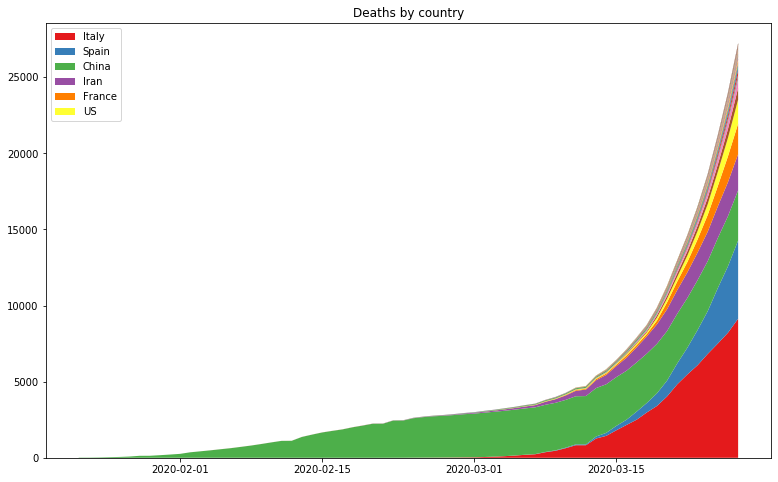

In [31]:
#6 deaths by country

df = df.sort_values(['Date','Deaths'], ascending = [False,False])
x = df[df['Country_Region'] == "Belgium"].Date
y = []
countries = []
for country in df['Country_Region'].unique():
    countries.append(country)
    y.append(list(df[df['Country_Region']==country].Deaths))

pal = sns.color_palette("Set1")
plt.figure(figsize=(13,8))

plt.stackplot(x,y, labels=countries[0:6], colors=pal, alpha=1)
plt.legend(loc='upper left')
plt.title('Deaths by country')

plt.show()